In [1]:
#pip install psycopg2-binary

In [2]:
#pip install sqlalchemy
import numpy as np
np.random.seed(0)

In [3]:
from sqlalchemy.engine import URL
from sqlalchemy import create_engine
import psycopg2
#print(sqlalchemy.__version__)
#print(psycopg2.__version__)
import pandas as pd
import plotly.io as pio
pio.renderers.default = "jpg"
# plotting libraries
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import TargetEncoder

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import train_test_split

In [4]:
# Information to connext to database
host = ''
port = ""
database = ''
username = ''
password = ''


url_object = URL.create(
    "postgresql",
    username=username,
    password=password,  
    host=host,
    database=database,
)

engine = create_engine(url_object)

# Connect to the database
conn = engine.connect()

print("We are set!")

We are set!


# First look tables

In [5]:
# Looking at Merchants
query = str(f"""
select * 
from analyst_recruitment_test.Merchants 
limit 5
""")
df = pd.read_sql(query, conn)

In [6]:
df.merchant_country.unique()

array(['CL'], dtype=object)

We only have chile, so all the district we will calculate later would be from this country

In [7]:
# Looking at Transactions
query = str(f"""
SELECT *
FROM analyst_recruitment_test.Transactions 
limit 5
""")
pd.read_sql(query, conn)

,transaction_id,merchant_id,server_time_created_at,tx_result,amount,card_id
0,4748257822,12764555,2023-06-25 23:40:05.136,SUCCESSFUL,1200.0,746412612
1,4631408107,9320639,2023-06-03 17:39:34.426,SUCCESSFUL,3240.0,569265418
2,4954622410,6291267,2023-08-04 23:49:40.795,SUCCESSFUL,20000.0,733583915
3,5322709735,4573128,2023-10-14 23:57:05.997,SUCCESSFUL,4200.0,1057736451
4,4741091141,8345864,2023-06-24 17:23:01.264,SUCCESSFUL,5850.0,800747638


In [8]:
# creating table to analyze
query = str(f"""
SELECT transaction_id, 
merchant_id,
tx_result,
amount,
card_id,
cast(extract(year from server_time_created_at) as integer) as year,
cast(extract(month from server_time_created_at) as integer) as month,
cast(extract(day from server_time_created_at) as integer) as day,
cast(extract(hour from server_time_created_at) as integer) as hour
FROM analyst_recruitment_test.Transactions 
ORDER BY YEAR DESC,MONTH DESC,DAY DESC, HOUR DESC
limit 5
""")
pd.read_sql(query, conn)

,transaction_id,merchant_id,tx_result,amount,card_id,year,month,day,hour
0,5398277841,15053921,SUCCESSFUL,5000.0,1009034675,2023,10,30,23
1,5398234880,12128384,SUCCESSFUL,5000.0,575981222,2023,10,30,23
2,5398305935,10382354,SUCCESSFUL,2850.0,1067881334,2023,10,30,23
3,5398280152,9169370,SUCCESSFUL,1350.0,940700967,2023,10,30,23
4,5398313480,7514506,FAILED,9170.0,388942600,2023,10,30,23


I also put the hour, maybe transactions too late or too early from a store that shouldn't be working at that hour can be a red flag. I would just leave this just in case...

In [9]:
# Looking the window of time we have
query = str(f"""
SELECT MAX(server_time_created_at),MIN (server_time_created_at)
FROM analyst_recruitment_test.Transactions 

""")
pd.read_sql(query, conn)

,max,min
0,2023-10-30 23:59:58.488,2023-06-01 00:00:31.373


We have only 4 full month and octuber we lack only one day, (So nearly 5 months)

# Question/Answer

# **A)**
What is the monthly Transaction Count per merchant for July, August and September 2023? What
can you say about the results?

Notice we do this only with Successful transactions to see the real movement!

In [10]:
query = str(f"""
SELECT *,
LAG(transaction_count) OVER(PARTITION BY merchant_id ORDER BY month ASC) AS LAG_TRANSACTION,
LEAD(transaction_count) OVER(PARTITION BY merchant_id ORDER BY month ASC) AS LEAD_TRANSACTION
FROM
(
SELECT merchant_id,count(transaction_id) as transaction_count,year,month
FROM
(
SELECT *
FROM
(
SELECT transaction_id, 
merchant_id,
tx_result,
amount,
card_id,
cast(extract(year from server_time_created_at) as integer) as year,
cast(extract(month from server_time_created_at) as integer) as month
FROM analyst_recruitment_test.Transactions 
) AS a
WHERE year=2023
AND month>=7
AND month<10
AND tx_result='SUCCESSFUL'
) AS b
GROUP BY year,month,merchant_id
) AS c
ORDER BY merchant_id,MONTH ASC

""")
df = pd.read_sql(query, conn)
df.head()

,merchant_id,transaction_count,year,month,lag_transaction,lead_transaction
0,1090764,2,2023,7,NaN,NaN
1,1238332,3,2023,7,NaN,2.0
2,1238332,2,2023,8,3.0,3.0
3,1238332,3,2023,9,2.0,NaN
4,1239919,11,2023,7,NaN,14.0


Because we only have three month and we just need to analyse for now the transaction, we are going to delete all month but the 8 that has all the information we need.

In [11]:
df = df[df['month']==8]

In [12]:
df.rename(columns={"lag_transaction": "July_transactions", 
                   "lead_transaction": "sep_transactions",
                   "transaction_count": "aug_transactions" }, inplace=True)

In [13]:
df['difference_t_previous_month'] = df['aug_transactions'] - df['July_transactions']
df['difference_t_next_month'] = df['sep_transactions'] - df['aug_transactions']

In [14]:
df.describe()

,merchant_id,aug_transactions,year,month,July_transactions,sep_transactions,difference_t_previous_month,difference_t_next_month
count,4.700000e+03,4700.000000,4700.0,4700.0,3809.000000,3674.000000,3809.000000,3674.000000
mean,1.066342e+07,32.868298,2023.0,8.0,39.377264,39.637997,-0.108690,-0.383506
std,3.894253e+06,70.738387,0.0,0.0,73.708511,77.207459,31.280258,30.884875
min,1.238332e+06,1.000000,2023.0,8.0,1.000000,1.000000,-368.000000,-691.000000
25%,7.835784e+06,2.000000,2023.0,8.0,4.000000,4.000000,-5.000000,-4.000000
50%,1.163556e+07,9.000000,2023.0,8.0,13.000000,14.000000,0.000000,0.000000
75%,1.373515e+07,31.000000,2023.0,8.0,42.000000,40.000000,4.000000,5.000000
max,1.612820e+07,1300.000000,2023.0,8.0,1260.000000,1363.000000,496.000000,559.000000


We can spot at a glance that there are some outliers in the transaction_count. 75% of the merchant has 31 transaction in a August, 42 in July, and 40 in September. But there are some merchant that has over a 1.000!

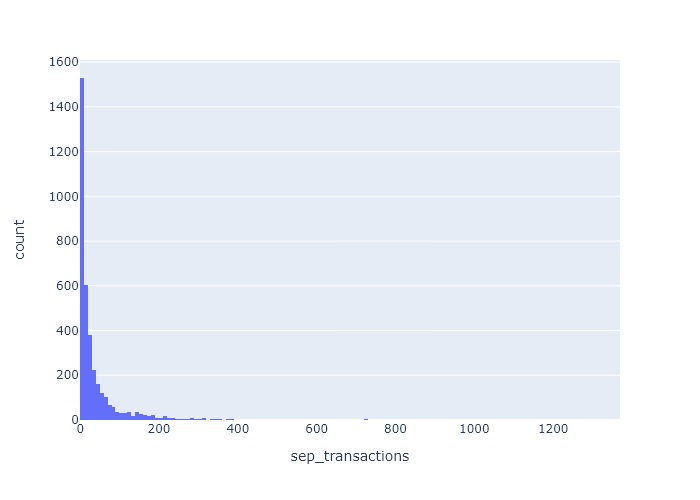

In [15]:
fig = px.histogram(df, x="sep_transactions")
fig.show()

Some question to answer:

how many marchant are only increase the amount of transactions? :)

how many are only descreasing? :(  

how many has variation (sometimes increase and other decrease) :/


In [16]:
df['growth'] = 'Not growing'
df.loc[(df['difference_t_previous_month']>0) & (df['difference_t_next_month']>0),'growth'] ='just growing'
df.loc[(df['difference_t_previous_month']<0) & (df['difference_t_next_month']<0),'growth'] ='just shrinking'

In [17]:
color_discrete_map = {
        "Not growing": 'blue', 
        "just growing": 'green', 
        "just shrinking": 'red'
    }

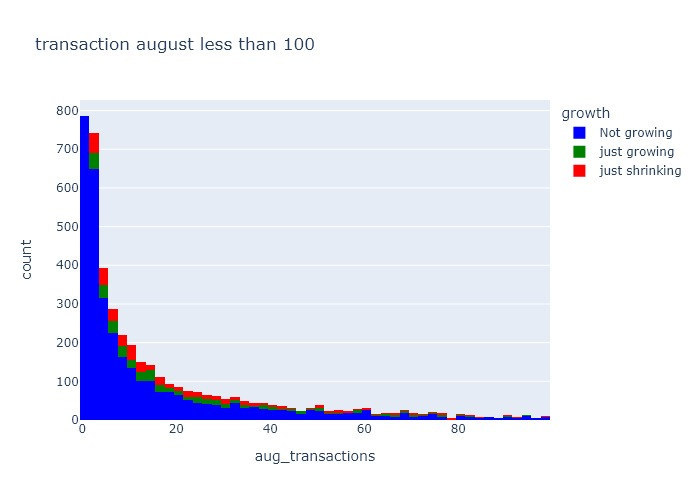

In [18]:
fig = px.histogram(df[df["aug_transactions"]<100], x="aug_transactions", color="growth",
                   color_discrete_map=color_discrete_map,
                  title = "transaction august less than 100")
fig.show()

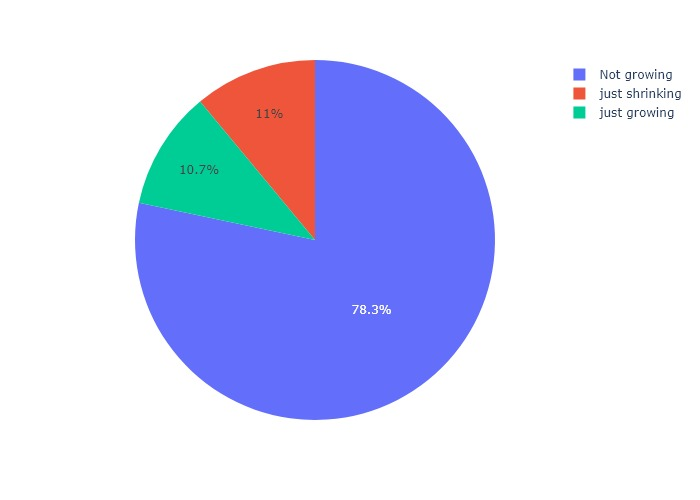

In [19]:
value_counts = df['growth'].value_counts()
value_counts_df = value_counts.reset_index()
value_counts_df.columns = ['growth', 'count']
fig = px.pie(value_counts_df, values='count', names='growth',color_discrete_map=color_discrete_map)
fig.show()

So we have nearly 80% merchant that are doing the same in terms of transaction (comparing just three months) and the rest is divided roughly equally between the ones that have only increase during that period their transtaction and the one that has only decrease them. In terms to which type of clients (thing about clients with high vs low transactions) we do not see a trend in the histogram (maybe we will need a model to see more in depth).

Other question that we could analyze, are there clients with zero transactions (they have null in their lag or lead) ? I will not explore this question further because I cannot be sure the cause of such behaviour (are they in holiday?, are they new merchand?, do they quit?, there are many possible reasons so I will not pursue to explore these merchand.)

# **B)**
Find the 10 districts in Chile with the highest TPV on all data available. For every one of those
districts, what is the merchant category that has the highest TPV? And the lowest? How would you
explain the results? 
We are going to consider the whole window of time that we have here (the nearly 5 month)

**We analyze just successful transactions**

In [20]:
query = str(f"""
SELECT merchant_district, 
category AS best_sell_category, 
TPV_district_category as TPV_category,
tpv_district as TPV_whole_district
FROM
(
SELECT *,
SUM(TPV_district_category) OVER(PARTITION BY merchant_district ORDER BY category_place DESC ) AS tpv_district
FROM
(
SELECT *,
ROW_NUMBER() OVER(PARTITION BY merchant_district ORDER BY TPV_district_category DESC) AS category_place
FROM
(
SELECT merchant_district,category, SUM(TPV) as TPV_district_category
FROM
(
SELECT m.merchant_id,merchant_district,mcc_level as category, TPV
FROM
(
SELECT merchant_id,
SUM(amount) AS TPV
FROM
(
SELECT transaction_id, 
merchant_id,
tx_result,
amount,
card_id
FROM analyst_recruitment_test.Transactions 
WHERE tx_result='SUCCESSFUL'
) AS a
GROUP BY merchant_id 
) AS b
LEFT JOIN analyst_recruitment_test.Merchants AS m on m.merchant_id = b.merchant_id
) as c
GROUP BY merchant_district,category
) AS d
) AS f
) AS g
WHERE category_place=1
ORDER BY tpv_district DESC
""")
df = pd.read_sql(query, conn)
df.head(10)

,merchant_district,best_sell_category,tpv_category,tpv_whole_district
0,Santiago,Café / Restaurant,56796876.0,347604770.0
1,Antofagasta,Newsstand / Magazines,107655776.0,325809660.0
2,Viña del Mar,Newsstand / Magazines,80425090.0,214212350.0
3,Puente Alto,Newsstand / Magazines,83435840.0,214178530.0
4,La Florida,Newsstand / Magazines,64869432.0,171500640.0
5,Providencia,Dentistry,49374744.0,152164100.0
6,Las Condes,Apparel,43051396.0,146819580.0
7,Valparaíso,Newsstand / Magazines,65325920.0,145804770.0
8,Peñalolén,Other Retail,56982472.0,142184540.0
9,Maipú,Newsstand / Magazines,46316152.0,136208960.0


This is the answer! But let us explore briefly about diversity!

In [21]:
df['weight_highest_category'] = df['tpv_category']/ df['tpv_whole_district']
df.head(10)

,merchant_district,best_sell_category,tpv_category,tpv_whole_district,weight_highest_category
0,Santiago,Café / Restaurant,56796876.0,347604770.0,0.163395
1,Antofagasta,Newsstand / Magazines,107655776.0,325809660.0,0.330425
2,Viña del Mar,Newsstand / Magazines,80425090.0,214212350.0,0.375446
3,Puente Alto,Newsstand / Magazines,83435840.0,214178530.0,0.389562
4,La Florida,Newsstand / Magazines,64869432.0,171500640.0,0.378246
5,Providencia,Dentistry,49374744.0,152164100.0,0.324484
6,Las Condes,Apparel,43051396.0,146819580.0,0.293227
7,Valparaíso,Newsstand / Magazines,65325920.0,145804770.0,0.448037
8,Peñalolén,Other Retail,56982472.0,142184540.0,0.400764
9,Maipú,Newsstand / Magazines,46316152.0,136208960.0,0.340037


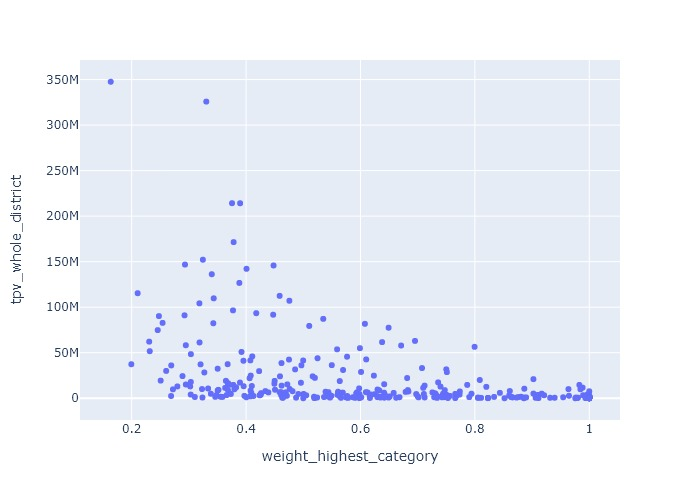

In [22]:
fig = px.scatter(df, x="weight_highest_category", y="tpv_whole_district")
            
fig.show()

So what it looks like just sniffing at the graph is that when the economy is big it is also diverse. That is an expected result generally when there is a business thriving generally spark the economy in the area and other businesses install in the same area to sell as well. Moreover it looks like an exponential decay in diversity. So what we can say about the top 10? Well they are outliers not only on whole district TPV but also in that those district has more categories to offer us. All of those 10 district are either on Región Metropolitana or in another big city. To be Honest I didn't expect Antofagasta, so I did learn something here.

# **c**
dimension from merchants table (age, legal type, etc.) that you think there could be diffenrences between groups in terms of Average Ticket and explain your findings. Justify your decision

I think the most important different should be in the category and maybe legal type (It different to buy something made by hand that for a company) and district. But we can explore that with a very simple model.

So we need a table with the average ticket and the information of merchants.

Other important point, we could use the table merchant because it has two interesting columns:

**lifetime_txs:** Integer Total number of transactions since first transaction

**lifetime_tpv:** Integer Total TPV since first transaction. (TPV = Total Payment Volume, the sum of amounts of successful transactions)

But the problem I see, is that I do not if that value that I would get it'll be nominative or real. Because there are some companies that have signed up a while ago. The other problem is that lifetime_txs I don't know if they are successful transaction or not. So we will stick with our trusty transaction table :) 


**We analyze just successful transactions**

In [23]:
query = str(f"""

SELECT m.*,TPV_merchant/number_transactions AS avg_ticket
FROM
(
SELECT merchant_id, count(transaction_id) as number_transactions,
sum(amount) as TPV_merchant
FROM analyst_recruitment_test.Transactions 
WHERE tx_result='SUCCESSFUL'
group by merchant_id
)AS A
LEFT JOIN analyst_recruitment_test.Merchants AS m on m.merchant_id = a.merchant_id

""")
df = pd.read_sql(query, conn)
df.head()

,merchant_id,date_of_birth,merchant_country,merchant_district,is_company,legal_type,mcc_level,signup_date,account_status,account_substatus,bank_account_status,bank_account_type,crod_week,crod_month,lifetime_txs,lifetime_tpv,avg_ticket
0,4289906,1987-03-04,CL,Colina,True,Empresa Individual de Responsabilidad Limitada...,Newsstand / Magazines,2019-03-29 22:39:30.856,ACTIVE,UNLIMITED,PASSED,CURRENT,2019-04-01,2019-04-01,15570.0,169102400.0,9496.201299
1,9484058,1958-08-08,CL,Copiapó,True,Sociedad por Acciones (SPA),Beauty / Barber,2021-01-15 16:48:43.406,ACTIVE,UNLIMITED,PASSED,CURRENT,2021-01-11,2021-01-01,5589.0,162306668.0,27850.299401
2,4653969,1985-01-12,CL,Peñalolén,False,Persona Natural,Other Retail,2019-05-14 18:18:40.821,ACTIVE,UNLIMITED,PASSED,CURRENT,2019-05-13,2019-05-01,59372.0,327219835.0,5225.558325
3,9600853,1953-04-14,CL,Antofagasta,False,Persona Natural,Newsstand / Magazines,2021-01-30 01:49:23.950,ACTIVE,UNLIMITED,PASSED,CUENTA_VISTA,2021-02-01,2021-02-01,8397.0,29705818.0,3428.745387
4,4585691,1970-08-24,CL,Antofagasta,True,Sociedad de Responsabilidad Limitada (SRL),Medical Services,2019-05-06 21:54:47.841,ACTIVE,UNLIMITED,PASSED,CURRENT,2019-05-06,2019-05-01,3617.0,87793420.0,32477.619048


In [24]:
df.dtypes

merchant_id                     int64
date_of_birth                  object
merchant_country               object
merchant_district              object
is_company                       bool
legal_type                     object
mcc_level                      object
signup_date            datetime64[ns]
account_status                 object
account_substatus              object
bank_account_status            object
bank_account_type              object
crod_week                      object
crod_month                     object
lifetime_txs                  float64
lifetime_tpv                  float64
avg_ticket                    float64
dtype: object

In [25]:
df.shape

(7657, 17)

In [26]:
df['date_of_birth'] = pd.to_datetime(df['date_of_birth'], format='%Y/%m/%d')

In [27]:
last_sign_up_date = df.signup_date.max()
last_sign_up_date

Timestamp('2023-10-29 23:11:53.474000')

In [28]:
## I will take the max date in the merchant to avoid problems like negative values just in case :)
df['last_signup_date'] = last_sign_up_date

In [29]:
df['month_since_existance_sign_up'] = (df.last_signup_date - df.signup_date) / np.timedelta64(1, 'M')
df['month_since_existance_sign_up'] = df['month_since_existance_sign_up'].astype(int)


df['month_since_existance'] = (df.last_signup_date - df.date_of_birth) / np.timedelta64(1, 'M')
df['month_since_existance'] = df['month_since_existance'].astype(int)
df.head()

,merchant_id,date_of_birth,merchant_country,merchant_district,is_company,legal_type,mcc_level,signup_date,account_status,account_substatus,bank_account_status,bank_account_type,crod_week,crod_month,lifetime_txs,lifetime_tpv,avg_ticket,last_signup_date,month_since_existance_sign_up,month_since_existance
0,4289906,1987-03-04,CL,Colina,True,Empresa Individual de Responsabilidad Limitada...,Newsstand / Magazines,2019-03-29 22:39:30.856,ACTIVE,UNLIMITED,PASSED,CURRENT,2019-04-01,2019-04-01,15570.0,169102400.0,9496.201299,2023-10-29 23:11:53.474,55,439
1,9484058,1958-08-08,CL,Copiapó,True,Sociedad por Acciones (SPA),Beauty / Barber,2021-01-15 16:48:43.406,ACTIVE,UNLIMITED,PASSED,CURRENT,2021-01-11,2021-01-01,5589.0,162306668.0,27850.299401,2023-10-29 23:11:53.474,33,782
2,4653969,1985-01-12,CL,Peñalolén,False,Persona Natural,Other Retail,2019-05-14 18:18:40.821,ACTIVE,UNLIMITED,PASSED,CURRENT,2019-05-13,2019-05-01,59372.0,327219835.0,5225.558325,2023-10-29 23:11:53.474,53,465
3,9600853,1953-04-14,CL,Antofagasta,False,Persona Natural,Newsstand / Magazines,2021-01-30 01:49:23.950,ACTIVE,UNLIMITED,PASSED,CUENTA_VISTA,2021-02-01,2021-02-01,8397.0,29705818.0,3428.745387,2023-10-29 23:11:53.474,32,846
4,4585691,1970-08-24,CL,Antofagasta,True,Sociedad de Responsabilidad Limitada (SRL),Medical Services,2019-05-06 21:54:47.841,ACTIVE,UNLIMITED,PASSED,CURRENT,2019-05-06,2019-05-01,3617.0,87793420.0,32477.619048,2023-10-29 23:11:53.474,53,638


In [30]:
df.isnull().sum()

merchant_id                       0
date_of_birth                     0
merchant_country                  0
merchant_district                 0
is_company                        0
legal_type                        0
mcc_level                         0
signup_date                       0
account_status                    0
account_substatus                 0
bank_account_status               0
bank_account_type                 0
crod_week                        13
crod_month                       13
lifetime_txs                      1
lifetime_tpv                      1
avg_ticket                        0
last_signup_date                  0
month_since_existance_sign_up     0
month_since_existance             0
dtype: int64

SO we have some nulls! Notice we will not use lifetime_txs and lifetime_tpv so that it is ok and we have 7657 values so 13 null it is nothing, I will just eliminate them. Also merchant_country we only have chile so it is not important! 

In [31]:
df["is_company"] = df["is_company"].apply(lambda x: 1 if x is True else 0)

In [32]:
#df.dropna(axis=0, subset=['crod_week',"crod_month"], inplace=True)
# I will take some of the variables because I will have to sparse data.  
df.drop(['lifetime_tpv','lifetime_txs','merchant_country',"signup_date","last_signup_date","date_of_birth",'crod_week',"crod_month","bank_account_type","account_substatus","merchant_id"], axis=1, inplace=True)

In [33]:
df.head()

,merchant_district,is_company,legal_type,mcc_level,account_status,bank_account_status,avg_ticket,month_since_existance_sign_up,month_since_existance
0,Colina,1,Empresa Individual de Responsabilidad Limitada...,Newsstand / Magazines,ACTIVE,PASSED,9496.201299,55,439
1,Copiapó,1,Sociedad por Acciones (SPA),Beauty / Barber,ACTIVE,PASSED,27850.299401,33,782
2,Peñalolén,0,Persona Natural,Other Retail,ACTIVE,PASSED,5225.558325,53,465
3,Antofagasta,0,Persona Natural,Newsstand / Magazines,ACTIVE,PASSED,3428.745387,32,846
4,Antofagasta,1,Sociedad de Responsabilidad Limitada (SRL),Medical Services,ACTIVE,PASSED,32477.619048,53,638


In [34]:
df.avg_ticket.describe()

count    7.657000e+03
mean     2.612233e+04
std      1.069888e+05
min      5.000000e+01
25%      4.467391e+03
50%      8.011842e+03
75%      1.726901e+04
max      5.000000e+06
Name: avg_ticket, dtype: float64

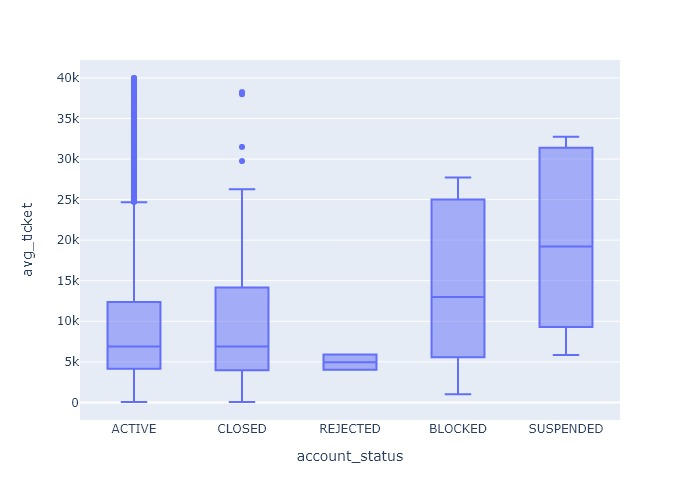

In [35]:
fig = px.box(df[df['avg_ticket']<40000 ], x="account_status", y="avg_ticket")
fig.show()

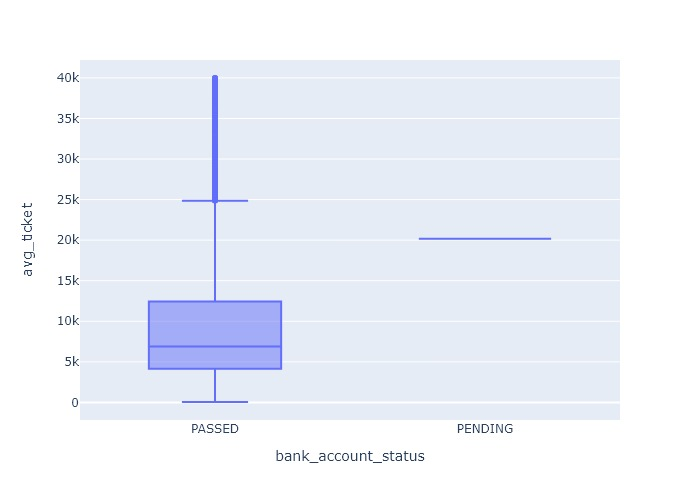

In [36]:
fig = px.box(df[df['avg_ticket']<40000 ], x="bank_account_status", y="avg_ticket")
fig.show()

In [37]:
df[df['bank_account_status']=="PENDING"]

,merchant_district,is_company,legal_type,mcc_level,account_status,bank_account_status,avg_ticket,month_since_existance_sign_up,month_since_existance
6129,Huechuraba,1,Sociedad por Acciones (SPA),Other Retail,ACTIVE,PENDING,20185.692308,16,459


In [38]:
df[df['merchant_district']=='Santiago'].merchant_district.count()

375

Somehow, someway the **block and suspended account** have higher ticket value by a little. Other point is that all the values with only one exception have bank account Passed in their status. So we will delete the bank account status.

In [39]:
df.drop(["bank_account_status"], axis=1, inplace=True)

In [40]:
# we have a lot of district
unique_district = len(list(df.merchant_district.unique()))

print(f""" We have on average of {round(df.shape[0]/unique_district,0)} merchand for district""")
print("")
print(f""" but Santiago has {round(df[df['merchant_district']=='Santiago'].merchant_district.count() ,0)} merchand""")


 We have on average of 24.0 merchand for district

 but Santiago has 375 merchand


In [41]:
df.merchant_district.value_counts()

Santiago        375
Antofagasta     277
Puente Alto     256
Maipú           203
Viña del Mar    195
               ... 
Licantén          1
Alto Biobío       1
Lolol             1
Empedrado         1
Rauco             1
Name: merchant_district, Length: 321, dtype: int64

So it will be difficult to create a model to actually use this very important variable, because there are a lot of district that has too little merchand (just 1) in their area to do a comprehensive analysis.

In [42]:
df.drop(["merchant_district"], axis=1, inplace=True)

In [43]:
df.isnull().any()

is_company                       False
legal_type                       False
mcc_level                        False
account_status                   False
avg_ticket                       False
month_since_existance_sign_up    False
month_since_existance            False
dtype: bool

In [44]:
y = df.avg_ticket
X = df.copy()
X.drop(['avg_ticket'], axis=1, inplace=True)

In [45]:
X, X_val, y, y_val = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                random_state=0)  

In [46]:
def transforming_modeling_scoring(X,y,n_estimators = 242, scoring='neg_mean_absolute_error'):

    numerical_col = [col for col in X.columns if str(X[col].dtypes)!='object' ] 
    
    categorical_col = [col for col in X.columns if str(X[col].dtypes)=='object' ] 
    
    # using this we will not create hot-encoding, it will create a number for each category related to the y value
    categorical_transformer =  Pipeline(steps=[
        ('encoder', TargetEncoder(smooth="auto",target_type='continuous'))
    ])

    preprocessor = ColumnTransformer(transformers=
        [("categorical_transformer", categorical_transformer, categorical_col)],remainder='passthrough')

    # Define model
    model = RandomForestRegressor(random_state=0,n_estimators = n_estimators)

    # Bundle preprocessing and modeling code in a pipeline
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                          ('model', model)
                         ])
    my_model = pipe.fit(X,y)
    
    # value was 242 with a mean MAE of 27017
    #distributions = dict(model__n_estimators=randint(low=50,high=500))
   
    # clf = RandomizedSearchCV(pipe, distributions, random_state=0, cv=cv,n_iter=n_iter,scoring=scoring, verbose=1)
    #search = clf.fit(X,y)
    
    return my_model

In [47]:
model = transforming_modeling_scoring(X,y)

In [48]:
perm = permutation_importance(model,X_val, y_val, random_state=0,scoring='neg_mean_absolute_error')

In [49]:
model_importances = pd.Series(perm.importances_mean, index=X_val.columns)
# the value with negative values are unimportant, because that means
# that changing the values of these columns actually improve the model
model_importances = model_importances[model_importances>0]
model_importances.sort_values(ascending=False)

mcc_level                        7085.541546
month_since_existance            1557.930479
month_since_existance_sign_up    1354.265258
legal_type                       1322.737353
is_company                        719.335376
account_status                     69.551360
dtype: float64

So, the result is what we expect, the most important variable for the model is the category follow by birth of the merchants, then when It sign up and then the legal type. The number are how much the MAE get affected if we switch the column values at random. (I prefer to use SHAP to this analysis but this is way faster.)

I little line about performance of the model:

I have a huge MAE (27.017), It is true that I just try a few hyperparameters in the random forest, maybe I need to try more values, but it is more probable that we need to captures more important variable that catch better the business to assest the avg ticket.

In [50]:
# let us create some graph about it mcc_level
df[['mcc_level','avg_ticket']].groupby('mcc_level').mean().reset_index().sort_values("avg_ticket",ascending=False)

,mcc_level,avg_ticket
12,Design Furniture,245633.207070
24,Medical Practitioner,162388.626026
11,Dentistry,116845.336848
14,Education,107006.004903
20,Hotel / Accommodation,92370.030575
5,Car Repair Shop,91141.806273
32,Other Service Providers,74219.407545
40,Tourism,72030.424371
16,Fitness / Wellness / Spa,66640.865313
34,Pharmacy and Nutrition,64014.001047


So we see huge difference here between business' categories! With food the business with the lower avg ticket and Design Furniture the higher one.

# **D.**
What is the average weekly Transaction Count for the top-ten merchants in terms of TPV? Has any
of these merchants been trending down in the past month on that KPI?


In [51]:
query = str(f"""

SELECT *,
LAG(transaction_count) OVER(PARTITION BY merchant_id ORDER BY week ASC) AS LAG_week_TRANSACTION,
LAG(week) OVER(PARTITION BY merchant_id ORDER BY week ASC) AS LAG_week,
LEAD(week) OVER(PARTITION BY merchant_id ORDER BY week ASC) AS LEAD_week,
LEAD(transaction_count) OVER(PARTITION BY merchant_id ORDER BY week ASC) AS LEAD_week_TRANSACTION
FROM
(
SELECT merchant_id,count(transaction_id) as transaction_count,week
FROM
(
SELECT *
FROM
(
SELECT transaction_id, 
merchant_id,
tx_result,
amount,
card_id,
cast(extract(year from server_time_created_at) as integer) as year,
cast(extract(month from server_time_created_at) as integer) as month,
cast(extract(week from server_time_created_at) as integer) as week
FROM analyst_recruitment_test.Transactions
WHERE merchant_id IN 
(
SELECT merchant_id
FROM
(SELECT merchant_id,SUM(amount) AS tpv FROM analyst_recruitment_test.Transactions 
GROUP BY merchant_id
ORDER BY tpv DESC
LIMIT 10
) AS sub_a
)
) AS a
WHERE tx_result='SUCCESSFUL'
) AS b
GROUP BY week,merchant_id
) AS c
ORDER BY merchant_id,week ASC

""")
df = pd.read_sql(query, conn)


In [52]:
df

,merchant_id,transaction_count,week,lag_week_transaction,lag_week,lead_week,lead_week_transaction
0,4438602,3,22,NaN,NaN,23.0,6.0
1,4438602,6,23,3.0,22.0,24.0,4.0
2,4438602,4,24,6.0,23.0,25.0,3.0
3,4438602,3,25,4.0,24.0,26.0,4.0
4,4438602,4,26,3.0,25.0,27.0,6.0
...,...,...,...,...,...,...,...
193,14632112,164,40,170.0,39.0,41.0,152.0
194,14632112,152,41,164.0,40.0,42.0,177.0
195,14632112,177,42,152.0,41.0,43.0,183.0
196,14632112,183,43,177.0,42.0,44.0,51.0


In [53]:
df['week_difference_lag_lead'] = df['lead_week']-df['lag_week']
df.week_difference_lag_lead.value_counts()

2.0     170
3.0       4
11.0      1
12.0      1
8.0       1
7.0       1
Name: week_difference_lag_lead, dtype: int64

So when we skip two weeks between lag and lead it means we have every week sales. But when we have 3 or more that means we have month without sales :( 
Likely that is very unlikely for the 10 merchand that has more sales!
Maybe they were on holiday (that is not the normal behaviour)

In [54]:
df[df['week_difference_lag_lead']>2]

,merchant_id,transaction_count,week,lag_week_transaction,lag_week,lead_week,lead_week_transaction,week_difference_lag_lead
15,4438602,1,37,5.0,36.0,39.0,13.0,3.0
16,4438602,13,39,1.0,37.0,40.0,11.0,3.0
113,11551769,1,23,1.0,22.0,33.0,1.0,11.0
114,11551769,1,33,1.0,23.0,35.0,1.0,12.0
115,11551769,1,35,1.0,33.0,41.0,1.0,8.0
116,11551769,1,41,1.0,35.0,42.0,1.0,7.0
133,13854916,13,38,7.0,37.0,40.0,2.0,3.0
134,13854916,2,40,13.0,38.0,41.0,2.0,3.0


In [55]:
df.merchant_id.value_counts()

4749446     23
5902348     23
9205144     23
14310797    23
14632112    23
4438602     22
4573128     21
13854916    19
14358755    14
11551769     7
Name: merchant_id, dtype: int64

So we have three merchant that have weeks without sales. The first and third are 4438602 and 13854916 but they only have 2 times around the same time without sales (a whole week without sales). Maybe a holiday that they did take off to relax. Both took one week. The second one 11551769 is a tricky one he has a lot of time between sales and he/she only sales one item per week. Probably sells one of the expensive categories we find in our previous question!

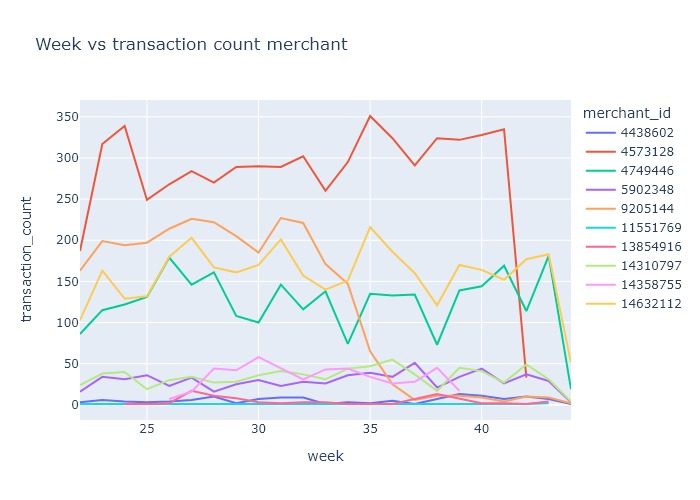

In [56]:
fig = px.line(df, x="week", y="transaction_count", color='merchant_id',title='Week vs transaction count merchant')
fig.show()

There are graph that look similar, like they have the same cicles (like line yellow and orange). They also present a big fall in the last week, maybe because the information of the last week it isn't over so we do not have the whole history.

It is hard to know without having a year of data if the values are actually increasing because We do not know if there are any cicles (for instance halloween can make an impact on some business!) 
But giving the few weeks we have we will giv it a shot!


In [57]:
df.week.value_counts()

33    10
35    10
42     9
26     9
27     9
28     9
29     9
30     9
31     9
32     9
41     9
34     9
36     9
37     9
40     8
43     8
22     8
39     8
23     8
25     8
24     8
38     8
44     6
Name: week, dtype: int64

Notice 44 is the last week but we do not have the 10 biggest TPV merchant of this window.
So I will take week 26 and 42 to see if there is any trend (with the above **caveat**).

In [58]:
df_26 = df[df['week']==26]
df_42 = df[df['week']==42]
df_comparison = df_26[['week','transaction_count','merchant_id']].merge(df_42[['week','transaction_count','merchant_id']] , on="merchant_id", how='outer')
df_comparison

,week_x,transaction_count_x,merchant_id,week_y,transaction_count_y
0,26.0,4.0,4438602,42.0,10.0
1,26.0,268.0,4573128,42.0,33.0
2,26.0,179.0,4749446,42.0,114.0
3,26.0,23.0,5902348,42.0,37.0
4,26.0,214.0,9205144,42.0,10.0
5,26.0,2.0,13854916,42.0,1.0
6,26.0,30.0,14310797,42.0,49.0
7,26.0,7.0,14358755,NaN,NaN
8,26.0,180.0,14632112,42.0,177.0
9,NaN,NaN,11551769,42.0,1.0


In [59]:
df_comparison['trend_16_weeks'] = df_comparison["transaction_count_y"]-df_comparison["transaction_count_x"]
df_comparison

,week_x,transaction_count_x,merchant_id,week_y,transaction_count_y,trend_16_weeks
0,26.0,4.0,4438602,42.0,10.0,6.0
1,26.0,268.0,4573128,42.0,33.0,-235.0
2,26.0,179.0,4749446,42.0,114.0,-65.0
3,26.0,23.0,5902348,42.0,37.0,14.0
4,26.0,214.0,9205144,42.0,10.0,-204.0
5,26.0,2.0,13854916,42.0,1.0,-1.0
6,26.0,30.0,14310797,42.0,49.0,19.0
7,26.0,7.0,14358755,NaN,NaN,NaN
8,26.0,180.0,14632112,42.0,177.0,-3.0
9,NaN,NaN,11551769,42.0,1.0,NaN


There is a trend downwards :( The merchant that sold more previously reduce a lot their transactions in the last weeks.
The merchant 14358755 is the pink line in the graph above, he/she stops selling before week 40. And merchant 11551769 we discuss it early (nearly always sales 1).

# **E.**
Find the date of the first and the last transaction for every merchant between the ages of 30 and 50.
Calculate the number of days between them and use this to calculate the average daily TPV and
Transaction Count.

Well the first **ever transaction** I cannot calculate, but I will assume it is just whatever appears in the transaction table for the first time.

I added the restriction that the account must be active, I was having problems because of how many register I was taking out.
I will also take out merchant with only one transaction, I could take them back in case needed just applying the complement in the last where, that is take all that has lead null, meaning they did only one transaction. 

I calculate age from birth until now.

In [60]:
query = str(f"""
SELECT merchant_id,
TOTAL_TRANSACTIONS,
total_tpv,
server_time_created_at AS FIRST_TRANSACTION,
LEAD_TIME AS LAST_TRANSACTION,
number_days,
total_tpv/number_days AS avg_daily_tpv,
cast(TOTAL_TRANSACTIONS as float)/number_days  AS avg_daily_transaction
FROM
(
SELECT *,
CAST(EXTRACT(DAY FROM LEAD_TIME::timestamp - server_time_created_at::timestamp) AS INT) + 2 AS number_days
FROM
(SELECT *,
LEAD(server_time_created_at) OVER(PARTITION BY merchant_id ORDER BY server_time_created_at ASC) AS LEAD_TIME
FROM
(
SELECT *, 
ROW_NUMBER() OVER(PARTITION BY merchant_id ORDER BY server_time_created_at ASC) AS FIRST_TRANSACTION_ORDER,
ROW_NUMBER() OVER(PARTITION BY merchant_id ORDER BY server_time_created_at DESC) AS LAST_TRANSACTION_ORDER,
SUM(amount)  OVER(PARTITION BY merchant_id ORDER BY server_time_created_at DESC) AS total_tpv,
count(transaction_id) OVER(PARTITION BY merchant_id ORDER BY server_time_created_at DESC) AS TOTAL_TRANSACTIONS
FROM analyst_recruitment_test.Transactions 
WHERE merchant_id IN
(
SELECT merchant_id
FROM 
(
SELECT 
DATE_PART('year', AGE(CURRENT_DATE,cast(date_of_birth as date ))) AS age_merchant,
*
FROM analyst_recruitment_test.Merchants 
) AS a
WHERE age_merchant>=30
AND age_merchant<=50
AND account_status ='ACTIVE'
) 
AND tx_result='SUCCESSFUL'
) AS b
WHERE FIRST_TRANSACTION_ORDER = 1 OR LAST_TRANSACTION_ORDER=1
) AS C
WHERE FIRST_TRANSACTION_ORDER = 1 
) AS d
WHERE LEAD_TIME IS NOT NULL
""")
df = pd.read_sql(query, conn)
df

,merchant_id,total_transactions,total_tpv,first_transaction,last_transaction,number_days,avg_daily_tpv,avg_daily_transaction
0,1090764,3,8069.0,2023-06-27 22:49:26.134,2023-07-01 21:36:04.392,5,1613.800000,0.600000
1,1237454,3,14000.0,2023-10-01 15:37:25.155,2023-10-01 18:13:36.676,2,7000.000000,1.500000
2,1238332,11,236000.0,2023-06-02 23:49:05.355,2023-10-06 22:12:04.123,127,1858.267717,0.086614
3,1241159,55,389550.0,2023-06-03 16:05:22.253,2023-10-30 22:06:05.665,151,2579.801325,0.364238
4,1247766,7,123500.0,2023-07-25 18:26:19.513,2023-09-15 19:00:28.056,54,2287.037037,0.129630
...,...,...,...,...,...,...,...,...
3563,16383283,4,7600.0,2023-10-27 23:53:13.563,2023-10-28 17:01:41.219,2,3800.000000,2.000000
3564,16383427,14,46300.0,2023-10-27 01:12:20.967,2023-10-27 03:20:44.057,2,23150.000000,7.000000
3565,16386310,86,780300.0,2023-10-27 16:53:29.610,2023-10-29 22:44:15.500,4,195075.000000,21.500000
3566,16391139,2,9000.0,2023-10-29 17:05:01.457,2023-10-29 20:20:48.860,2,4500.000000,1.000000


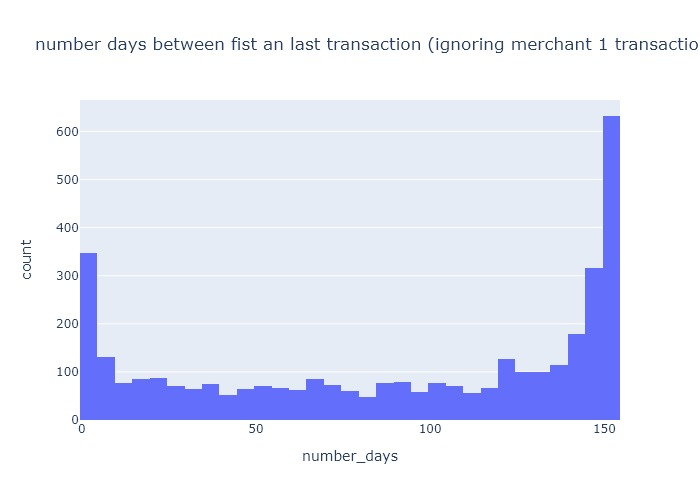

In [61]:
fig = px.histogram(df, x="number_days",
                  title = "number days between fist an last transaction (ignoring merchant 1 transaction)")
fig.show()

In [62]:
df.number_days.value_counts()[:10]

153    284
2      220
152    163
149    113
151    108
148     84
3       79
150     77
147     54
4       48
Name: number_days, dtype: int64

So we can see the majority of merchant sell since the beginning of the 5 month window. There is other big group that just sell two different days (beginning date and end date are just one day apart!)

In [63]:
df.describe()

,merchant_id,total_transactions,total_tpv,number_days,avg_daily_tpv,avg_daily_transaction
count,3.568000e+03,3568.000000,3.568000e+03,3568.000000,3568.000000,3568.000000
mean,1.082991e+07,113.030549,1.003202e+06,90.468049,12671.556269,1.344256
std,4.029742e+06,302.787821,2.473839e+06,55.314541,31492.304475,2.917085
min,1.090764e+06,2.000000,1.000000e+02,2.000000,5.263158,0.015625
25%,7.916049e+06,6.000000,6.835000e+04,37.000000,1600.934517,0.130686
50%,1.176904e+07,21.000000,2.555500e+05,103.000000,4527.477042,0.396743
75%,1.437530e+07,86.000000,8.956285e+05,146.000000,12427.488464,1.234686
max,1.639167e+07,5947.000000,3.767482e+07,153.000000,933476.500000,42.784173


Giving some outliers (total_tp, avg_daily_tpv, and avg_daily_transaction ) we are going to take out some of these elements to plot.

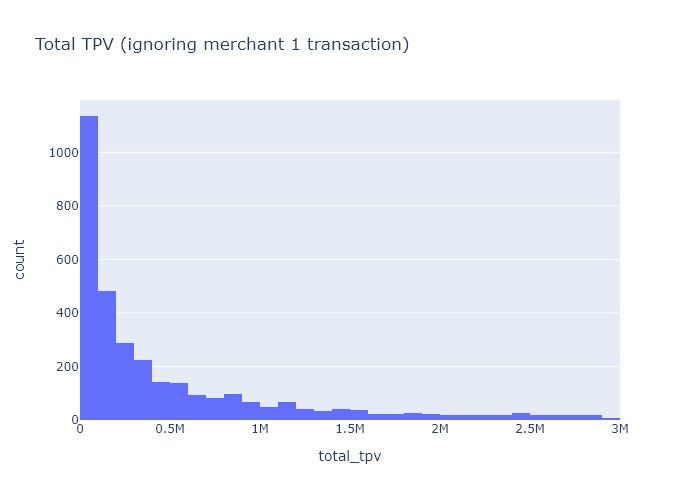

In [64]:
fig = px.histogram(df[df["total_tpv"]<3000000] , x="total_tpv",
                  title = "Total TPV (ignoring merchant 1 transaction)")
fig.show()

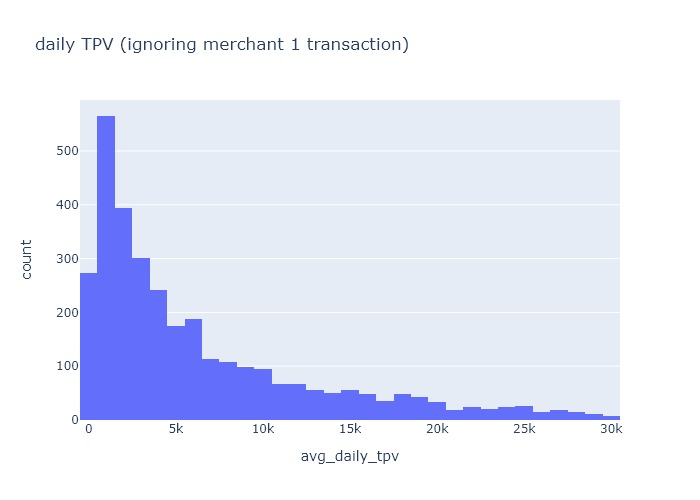

In [65]:
fig = px.histogram(df[df["avg_daily_tpv"]<30000] , x="avg_daily_tpv",
                  title = "daily TPV (ignoring merchant 1 transaction)")
fig.show()

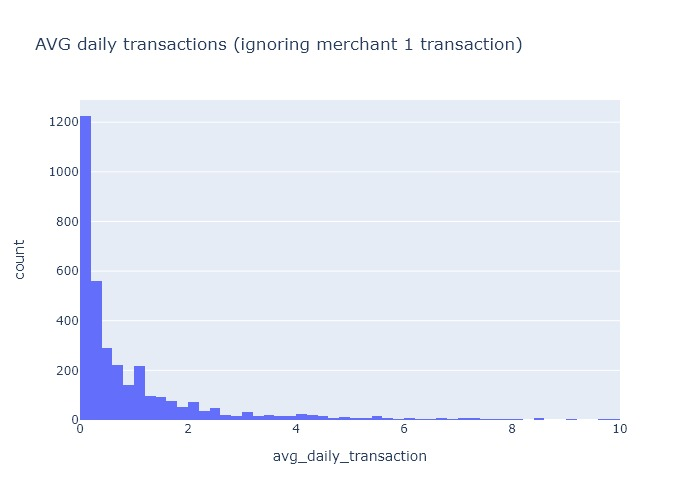

In [66]:
fig = px.histogram(df[df['avg_daily_transaction']<10] , x="avg_daily_transaction",
                  title = "AVG daily transactions (ignoring merchant 1 transaction)")
fig.show()

## Conclusion

Generally we just see a few daily transaction (less than 4), through the whole windows of time (they sale during the 5 month we have of data). If we take the outliers we have a generally 5000 TPV daily (quite low to be honest). 

**Notice that the average it is constructed with the last day of sale vs the first one**. It is not the number of tpv giving the actual days they sell. In other words, if a company usually sales monday to friday. And I have the first transaction a monday and the last the next monday, here I am dividing by 7 and not 5. So the number can be lower at what the actually need to be. 

Giving all the explanation above, consider this number that I have here like the daily revenue and transaction it gives the employer daily irrespectively if they are working or not. To this analysis we should count the number of different days that occured transaction and that would be the **real value**. That can be done with Dense rank and taking current date difference in days with the transaction date and it solves the issue. I will not do it because it is not the answer to this question.


# **F**
Build a query that returns the daily, weekly and monthly Average Ticket for every merchant category. Query result needs to be at the day level (in other words, query must return groups of merchant
category + every day on database). Hint: one way to do it is by using window functions.

This look like an interesting mixed of what we have done so far!

In [67]:
query = str(f"""
SELECT mcc_level, 
day,
month,
daily_avg_ticket,
weekly_tpv_ticket/weekly_transaction_ticket AS weekly_avg_ticket,
monthly_tpv_ticket/monthly_transaction_ticket AS monthly_avg_ticket
FROM
(
SELECT *, 
daily_tpv_category/daily_transaction_category AS daily_avg_ticket,
SUM(daily_tpv_category) OVER(PARTITION BY mcc_level,month,week ORDER BY month,week,day ) as weekly_tpv_ticket,
SUM(daily_transaction_category) OVER(PARTITION BY mcc_level,month,week ORDER BY month,week,day ) as weekly_transaction_ticket,

SUM(daily_tpv_category) OVER(PARTITION BY mcc_level,month ORDER BY month,week,day ) as monthly_tpv_ticket,
SUM(daily_transaction_category) OVER(PARTITION BY mcc_level,month ORDER BY month,week,day ) as monthly_transaction_ticket

FROM
(SELECT mcc_level,
month, week, day, 
SUM(daily_tpv) as daily_tpv_category, 
sum(daily_transaction) as daily_transaction_category
FROM
(
SELECT c.*,mcc_level 
FROM
(
SELECT merchant_id,
sum(amount) as daily_tpv, 
day,week,month,
count(transaction_id) as daily_transaction
FROM
(
SELECT *
FROM
(
SELECT transaction_id, 
merchant_id,
tx_result,
amount,
card_id,
cast(extract(month from server_time_created_at) as integer) as month,
cast(extract(week from server_time_created_at) as integer) as week,
cast(extract(day from server_time_created_at) as integer) as day
FROM analyst_recruitment_test.Transactions
) AS a
WHERE tx_result='SUCCESSFUL'
) AS b
GROUP BY day,week,month,merchant_id
) AS c
LEFT JOIN analyst_recruitment_test.Merchants AS m ON m.merchant_id = c.merchant_id
) AS d
GROUP BY mcc_level, month, week, day
) AS e
) AS f

""")
df = pd.read_sql(query, conn)
df

,mcc_level,day,month,daily_avg_ticket,weekly_avg_ticket,monthly_avg_ticket
0,Apparel,1,6,20573.114865,20573.114865,20573.114865
1,Apparel,2,6,20886.532468,20732.937086,20732.937086
2,Apparel,3,6,16634.984252,18860.850719,18860.850719
3,Apparel,4,6,13974.285714,17877.920977,17877.920977
4,Apparel,5,6,12529.855072,12529.855072,16992.989209
...,...,...,...,...,...,...
5930,Veterinary,26,10,32979.655172,32880.689655,31090.794393
5931,Veterinary,27,10,45888.181818,34954.347826,31581.069277
5932,Veterinary,28,10,26870.000000,34408.108108,31511.172107
5933,Veterinary,29,10,42053.846154,35025.465839,31710.669578


# BONUS 

Well I think you can asset my analytical skills by the work I already made until here, so will just point what I would analyze briefly without doing the queries (I know I should do the queries for the bonus, but I will just point, because I think my actual code until now it is quite big and I do not want to extend it even further)

**Consistency**
- I would analyze consistency, we shouldn't have transaction on merchant that do not have an active account
- We should have sign up before our service where up.

**Analyzis**
- What are the clients that are leaving us :( what are their caracteristics (demografic)
- Giving their sales, can we know when I client is going to quit his or her business

**Other points**
- It would be nice to know the gender of the person, if we want to send an email or analyze if their behaviour or category difference between man and woman.
- It is any difference between sign up date and the month when they purchase the card reader, which types of merchant are more hesitant to buy it? 